In [3]:
import sys
sys.path.append("../")

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from tqdm.notebook import tqdm as notebook_tqdm

import shap

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from src.modelling.feature_extraction import Feature_Extraction as FE


from src.data.etl_layer import ETL
from src.data.eda_layer import EDA
from src.modelling.data_validation import Data_Validation as DV
from src.modelling.model_error_analysis import ModelErrorAnalysis as MEA


import joblib
import tensorflow_data_validation as tfdv

2024-03-19 22:50:01.514453: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 22:50:01.514484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 22:50:01.515405: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-19 22:50:01.521145: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 22:50:02.512153: W tensorflow/compiler/tf2

# CREATION SIMPLE MODEL

## XGBoost

In [4]:

from src.data.etl_layer import ETL

sales_etl = ETL("../data/raw/sales_train.csv")

sales_etl.transform(["item_cnt_day"], ["item_cnt_day"])
sales_df = sales_etl.get_data()

def feature_extraction(processed_sales_df, full_processed_monthly_df):
    processed_sales_df["month"] = processed_sales_df["date"].dt.to_period("M")
    
    month_mean_price = processed_sales_df.groupby(["month", "shop_id", "item_id"])["item_price"].mean()
    month_mean_price.reset_index(drop=True, inplace=True)

    full_processed_monthly_df["mean_month_price"] = month_mean_price

    full_processed_monthly_df['month_num'] = full_processed_monthly_df['month'].dt.month

    # monthly_etl = ETL(df=full_processed_monthly_df)
    # monthly_etl.transform(["item_cnt_month"], ["item_cnt_month"])

    # full_processed_monthly_df = monthly_etl.get_data()

    full_processed_monthly_df.drop("month", axis=1, inplace=True)

    return full_processed_monthly_df

monthly_df = pd.read_csv("../data/processed/monthly_sales_full_processed.csv", parse_dates=["month"])
train_df = feature_extraction(sales_df, monthly_df)

print("TRAIN DF TRANS")

train_etl = ETL(df=train_df)
train_etl.transform(["item_cnt_month"], ["item_cnt_month"])
train_df = train_etl.get_data()

def get_train_test_data(train_df, test_size):
    X = train_df.drop(["item_cnt_month"], axis=1).values
    y = train_df[["item_cnt_month"]].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_data(train_df, 0.3)

train_df



2935849 rows and 6 columns has been read from sales_train.csv

306477 outliers were found for the item_cnt_day column.

306477 outliers in column item_cnt_day processed.

Number of rows with missing values: 0

0 rows with N/A values processed.

Number of conflicting or duplicated rows: 6

6 inconsistent or duplicated rows processed.

Сolumns with presumably the wrong data type: 
not numeric type columns: [],
not date type columns: ['date'],
not string type columns: []

DataFrame column types processed.
TRAIN DF TRANS

1609124 rows and 5 columns has been read from Dataset

43328 outliers were found for the item_cnt_month column.

43328 outliers in column item_cnt_month processed.

Number of rows with missing values: 0

0 rows with N/A values processed.

Number of conflicting or duplicated rows: 86639

86639 inconsistent or duplicated rows processed.

Сolumns with presumably the wrong data type: 
not numeric type columns: [],
not date type columns: [],
not string type columns: []

DataF

,shop_id,item_id,item_cnt_month,mean_month_price,month_num
0,0,32,1.870712,221.0,1
1,0,33,3.000000,347.0,1
2,0,35,1.000000,247.0,1
3,0,43,1.000000,221.0,1
4,0,51,2.000000,128.5,1
...,...,...,...,...,...
1609119,59,22087,1.336636,119.0,10
1609120,59,22088,2.000000,119.0,10
1609121,59,22091,1.000000,179.0,10
1609122,59,22100,1.000000,629.0,10


In [9]:
sales_etl = ETL("../data/raw/sales_train.csv")
sales_df = sales_etl.get_data()


2935849 rows and 6 columns has been read from sales_train.csv


In [10]:
monthly_df = FE(sales_df).monthly_df

In [11]:
monthly_df.to_csv("../data/processed/monthly_sales.csv")

In [19]:
X_train = pd.DataFrame(X_train, columns=train_df.drop("item_cnt_month", axis=1).columns)

лучший скор (0.55) со всеми фичами без эмбеддинга, с эмбеддингом 0.56

In [5]:
model = CatBoostRegressor(cat_features=["shop_id", "item_id", "month_num"])
model = model.load_model("../models/CatBoost")

In [22]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.33, shuffle=False)

In [23]:
model.fit(X_train, y_train, eval_set=(X_val, y_val))

In [31]:
model.save_model("../models/CatBoost")

In [16]:
train_df.reset_index(drop=True, inplace=True)

train_df_dv = DV()
train_df_dv.create_stats(train_df)
train_df_dv.save_schema("train_data_schema")
train_df_dv.save_stats("train_data_stats")


# stats = tfdv.generate_statistics_from_dataframe(train_df)
# tfdv.write_stats_text(stats, 'train_data_stats.txt')

The Data Stats has been successfully created
There is no schema.
Trying to create a schema...
The schema has been successfully created


,Type,Presence,Valency,Domain
Feature name,,,,
'shop_id',INT,required,,-
'item_id',INT,required,,-
'item_cnt_month',FLOAT,required,,-
'mean_month_price',FLOAT,required,,-
'month_num',INT,required,,-


The data schema has been successfully saved in '../data/data_validation/train_data_schema.pbtxt'
The data stats has been successfully saved in '../data/data_validation/train_data_stats.txt'


In [24]:
i_data = pd.read_csv("../data/raw/test.csv")[:400000]

In [25]:
i_data_dv = DV()
i_data_stats = i_data_dv.create_stats(i_data)

The Data Stats has been successfully created


In [26]:
raw_data_dv: DV = DV()
raw_data_dv.load_schema("../data/data_validation/raw_data_schema.pbtxt")
raw_data_dv.load_stats("../data/data_validation/raw_data_stats.txt")

raw_validate_stats = raw_data_dv.validate_data(i_data_stats)

,Anomaly short description,Anomaly long description
Feature name,,
'ID',New column,New column (column in data but not in schema)
'item_price',Column dropped,Column is completely missing
'item_cnt_day',Column dropped,Column is completely missing
'date',Column dropped,Column is completely missing
'date_block_num',Column dropped,Column is completely missing


In [27]:
if raw_validate_stats.anomaly_info:
    print("j")

j


In [36]:
sales_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [35]:
sales_df.dtypes["date"] == "object"

True

In [ ]:
tfdv.load_statistics('../data/data_validation/train_data_stats.txt')

In [8]:
sales_etl = ETL("../data/raw/sales_train.csv")
sales_df = sales_etl.get_data()


2935849 rows and 6 columns has been read from sales_train.csv


In [10]:
sales_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [11]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [12]:
saled_df_dv = DV()
saled_df_dv.create_stats(sales_df)
saled_df_dv.save_schema("raw_data_schema")
saled_df_dv.save_stats("raw_data_stats")

The Data Stats has been successfully created
There is no schema.
Trying to create a schema...
The schema has been successfully created


,Type,Presence,Valency,Domain
Feature name,,,,
'date',BYTES,required,,-
'date_block_num',INT,required,,-
'shop_id',INT,required,,-
'item_id',INT,required,,-
'item_price',FLOAT,required,,-
'item_cnt_day',FLOAT,required,,-


The data schema has been successfully saved in '../data/data_validation/raw_data_schema.pbtxt'
The data stats has been successfully saved in '../data/data_validation/raw_data_stats.txt'


In [15]:
saled_df_dv = DV()
saled_df_dv.load_schema("../data/data_validation/raw_data_schema.pbtxt")
saled_df_dv.load_stats("../data/data_validation/raw_data_stats.txt")
saled_df_dv.stats
tfdv.display_schema(saled_df_dv.schema)



,Type,Presence,Valency,Domain
Feature name,,,,
'date',BYTES,required,,-
'date_block_num',INT,required,,-
'shop_id',INT,required,,-
'item_id',INT,required,,-
'item_price',FLOAT,required,,-
'item_cnt_day',FLOAT,required,,-


In [28]:
y_pred = model.predict(X_test)
root_mean_squared_error(y_pred, y_test)

0.5754681554136255

In [5]:
y_test = y_test.ravel()

In [6]:
mea = MEA(model, X_test, y_test)

KeyboardInterrupt: 

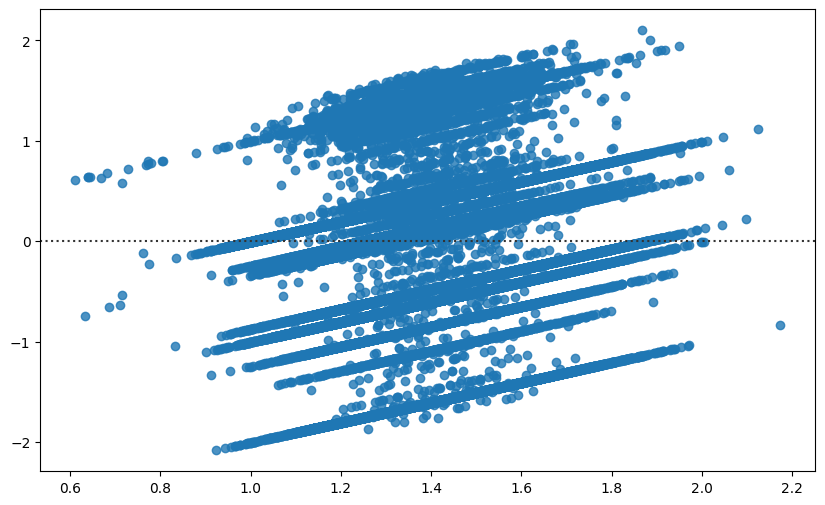

In [7]:
mea.plot_residuals()

In [34]:
test_df = ETL("../data/raw/test.csv").get_data()

_, test_embr = data_preprocessing(test_df[["shop_id", "item_id"]].values)


214200 rows and 3 columns has been read from test.csv


In [35]:
results = model.predict(test_embr)

In [36]:
results_df = pd.DataFrame(results, columns=["item_cnt_month"])
results_df.index.name = "ID"

In [37]:
results_df.head()

,item_cnt_month
ID,
0,1.663852
1,1.180580
2,1.637313
3,1.213278
4,1.133725


In [38]:
results_df.to_csv("../data/results.csv")

# DATA

In [4]:
# Creating a dataframe with unique store-item pairs 
# for subsequent time series analysis for these pairs
shop_item_gr: pd.DataFrame = pd.DataFrame(sales_df.groupby(["shop_id", "item_id"])["item_cnt_day"].sum())
shop_item_df = shop_item_gr.reset_index() # converting indexes into columns
shop_item_df = shop_item_df[["shop_id", "item_id"]]

In [ ]:
# ts stationarity check for unique shop-item pairs 
import warnings


warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="The test statistic is outside of the range of p-values")

nonstationary_shop_item = []
for r in shop_item_df.iterrows():
    shop_id: int = r[1]["shop_id"]
    item_id: int = r[1]["item_id"]

    shop_item_ts: pd.DataFrame = monthly_df.loc[(monthly_df["shop_id"] == shop_id) & (monthly_df["item_id"] == item_id)]
    if shop_item_ts.shape[0] >= 20:
        shop_item_stationarity: tuple = EDA(shop_item_ts).ts_stationarity_check("item_cnt_month")
        if shop_item_stationarity[0] != "stationary": 
            nonstationary_shop_item.append({"shop_id": shop_id, "item_id": item_id, "stationarity" : shop_item_stationarity[0], "tests_stats": {"adf_stats" : shop_item_stationarity[1], "kpss_stats" : shop_item_stationarity[2]}})
            # print(f"For {shop_id} shop_id and {item_id} item_id time series is {shop_item_stationarity[0]}.")

In [ ]:
# non-stationarity processing for unique shop-item pairs 
for shop_item in nonstationary_shop_item:
    shop_id: int = shop_item["shop_id"]
    item_id: int = shop_item["item_id"]

    shop_item_ts: pd.DataFrame = monthly_df.loc[(monthly_df["shop_id"] == shop_id) & (monthly_df["item_id"] == item_id)]
    shop_item_ts_etl: ETL = ETL(df=shop_item_ts)
    proc_shop_item_ts: pd.DataFrame = shop_item_ts_etl.ts_nonstatinarity_processing("item_cnt_month")
    monthly_df.loc[(monthly_df["shop_id"] == shop_id) & (monthly_df["item_id"] == item_id), "item_cnt_month"] = proc_shop_item_ts
    # print(f"TS for {shop_id} shop and {item_id} item processed.")
    

In [3]:
# save full processed monthly dataframe
monthly_df.to_csv("../data/processed/monthly_sales_full_processed.csv", index=False)

NameError: name 'monthly_df' is not defined

# FEATURE EXTRACTION STEP

In [6]:
train_df.head()

,shop_id,item_id,item_cnt_month,mean_month_price,month_num,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_7,item_cnt_month_lag_8,item_cnt_month_lag_9,item_cnt_month_lag_10,item_cnt_month_lag_11,item_cnt_month_lag_12
12,0,149,3.0,99.0,1,1.0,1.870712,1.000000,1.000000,1.000000,1.000000,1.0,2.0,1.0,1.0,3.0,1.870712
13,0,151,1.0,75.0,1,3.0,1.000000,1.870712,1.000000,1.000000,1.000000,1.0,1.0,2.0,1.0,1.0,3.000000
14,0,153,1.0,258.0,1,1.0,3.000000,1.000000,1.870712,1.000000,1.000000,1.0,1.0,1.0,2.0,1.0,1.000000
15,0,198,1.0,112.0,1,1.0,1.000000,3.000000,1.000000,1.870712,1.000000,1.0,1.0,1.0,1.0,2.0,1.000000
16,0,210,2.0,118.0,1,1.0,1.000000,1.000000,3.000000,1.000000,1.870712,1.0,1.0,1.0,1.0,1.0,2.000000


In [11]:


X_train, X_test, y_train, y_test = get_train_test_data(train_df, 0.3)

y_train = y_train.ravel()
y_test = y_test.ravel()

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "SVR": SVR(C=1.0, epsilon=0.5, max_iter=100),
    "XGBoost": XGBRegressor(eval_metric="rmse"),
    "CatBoost": CatBoostRegressor(100, loss_function="RMSE", verbose=100)
}

for name, model in models.items():
    model.fit(X_train, y_train)  
    predictions = model.predict(X_test)  
    rmse = root_mean_squared_error(y_test, predictions)
    print(f"{name}: RMSE = {rmse:.4f}")

Linear Regression: RMSE = 0.5926
Random Forest: RMSE = 0.5901


/home/user/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVR: RMSE = 0.5937
XGBoost: RMSE = 0.5795
Learning rate set to 0.5
0:	learn: 0.5712545	total: 120ms	remaining: 11.9s
99:	learn: 0.5557358	total: 7.63s	remaining: 0us
CatBoost: RMSE = 0.5790


In [16]:
import joblib

joblib.dump(models["Linear Regression"], f'../models/"Linear Regression".pkl')
joblib.dump(models["Random Forest"], f'../models/"Random Forest".pkl')
joblib.dump(models["SVR"], f'../models/"SVR".pkl')
models["XGBoost"].save_model("../models/XGBoost.bin")
models["CatBoost"].save_model("../models/CashaptBoost", format="cbm")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:08:30] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [12]:
catboost_model = CatBoostRegressor()
catboost_model = catboost_model.load_model("../models/CatBoost")

# FEATURE IMPORTANCE LAYER

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


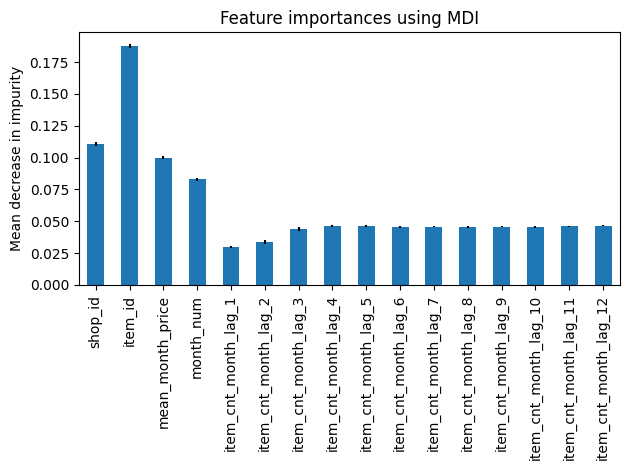

In [60]:
# FEATURE IMPORTANCE impurity

feature_names = train_df.drop("item_cnt_month", axis=1).columns
forest = joblib.load("../models/Random Forest.pkl")

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
print(type(std))
forest_importances = pd.Series(importances, index=feature_names)
print(type(forest_importances))

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [46]:
import joblib
rfr = joblib.load('../models/Random Forest.pkl')

In [63]:
#BORUTA IMPORTANCE
from boruta import BorutaPy

np.int = np.int32
np.float = np.float64
np.bool = np.bool_

rfr = RandomForestRegressor(n_jobs=-1, max_depth=5)

boruta_selector = BorutaPy(rfr, n_estimators='auto', max_iter=3, verbose=2, random_state=42)

y_train = y_train.ravel()
y_test = y_test.ravel()

boruta_selector.fit(X_train, y_train)


green_area = feature_names[boruta_selector.support_].to_list()
blue_area = feature_names[boruta_selector.support_weak_].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)

# if hasattr(boruta_selector.estimator_, 'feature_importances_'):
#     feature_importances = boruta_selector.estimator_.feature_importances_
# else:
#     print("Выбранная модель не предоставляет важности признаков.")

# feature_names = np.array(X_train.columns)

# sorted_idx = np.argsort(feature_importance)[::-1]

# # Отображение важности признаков
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(feature_importance)), feature_importance[sorted_idx], align='center')
# plt.xticks(range(len(feature_importance)), feature_names[sorted_idx], rotation=90)
# plt.xlabel('Features')
# plt.ylabel('Importance')
# plt.title('Feature Importance')
# plt.show()

Iteration: 	1 / 3
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	2 / 3
Confirmed: 	0
Tentative: 	16
Rejected: 	0


BorutaPy finished running.

Iteration: 	3 / 3
Confirmed: 	0
Tentative: 	10
Rejected: 	0


NameError: name 'X' is not defined

In [71]:
feature_ranks = list(zip(feature_names, 
                                boruta_selector.ranking_, 
                                boruta_selector.support_))
        
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2])) 

Feature: shop_id                   Rank: 2,  Keep: False
Feature: item_id                   Rank: 2,  Keep: False
Feature: mean_month_price          Rank: 2,  Keep: False
Feature: month_num                 Rank: 6,  Keep: False
Feature: item_cnt_month_lag_1      Rank: 2,  Keep: False
Feature: item_cnt_month_lag_2      Rank: 2,  Keep: False
Feature: item_cnt_month_lag_3      Rank: 2,  Keep: False
Feature: item_cnt_month_lag_4      Rank: 2,  Keep: False
Feature: item_cnt_month_lag_5      Rank: 4,  Keep: False
Feature: item_cnt_month_lag_6      Rank: 5,  Keep: False
Feature: item_cnt_month_lag_7      Rank: 3,  Keep: False
Feature: item_cnt_month_lag_8      Rank: 2,  Keep: False
Feature: item_cnt_month_lag_9      Rank: 2,  Keep: False
Feature: item_cnt_month_lag_10     Rank: 7,  Keep: False
Feature: item_cnt_month_lag_11     Rank: 2,  Keep: False
Feature: item_cnt_month_lag_12     Rank: 7,  Keep: False


In [64]:
green_area = feature_names[boruta_selector.support_].to_list()
blue_area = feature_names[boruta_selector.support_weak_].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)

features in the green area: []
features in the blue area: ['shop_id', 'item_id', 'mean_month_price', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_4', 'item_cnt_month_lag_8', 'item_cnt_month_lag_9', 'item_cnt_month_lag_11']


# EXPLAINABILITY

In [10]:
mmm = CatBoostRegressor()
mmm.load_model("../models/CatBoost")

NameError: name 'CatBoostRegressor' is not defined

In [8]:
y_pred = model.predict(X_test)

root_mean_squared_error(y_pred, y_test)

0.5743458251372096

In [18]:
shap.initjs()
train_df.head()

,shop_id,item_id,item_cnt_month,mean_month_price,month_num,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_7,item_cnt_month_lag_8,item_cnt_month_lag_9,item_cnt_month_lag_10,item_cnt_month_lag_11,item_cnt_month_lag_12
12,0,149,3.0,99.0,1,1.0,1.870712,1.000000,1.000000,1.000000,1.000000,1.0,2.0,1.0,1.0,3.0,1.870712
13,0,151,1.0,75.0,1,3.0,1.000000,1.870712,1.000000,1.000000,1.000000,1.0,1.0,2.0,1.0,1.0,3.000000
14,0,153,1.0,258.0,1,1.0,3.000000,1.000000,1.870712,1.000000,1.000000,1.0,1.0,1.0,2.0,1.0,1.000000
15,0,198,1.0,112.0,1,1.0,1.000000,3.000000,1.000000,1.870712,1.000000,1.0,1.0,1.0,1.0,2.0,1.000000
16,0,210,2.0,118.0,1,1.0,1.000000,1.000000,3.000000,1.000000,1.870712,1.0,1.0,1.0,1.0,1.0,2.000000


In [31]:
X_train = pd.DataFrame(X_train, columns=train_df.drop("item_cnt_month", axis=1).columns)
y_train = pd.DataFrame(y_train, columns=["item_cnt_month"])

In [35]:
mmmmm = CatBoostRegressor(cat_features=["shop_id", "item_id", "month_num"])

mmmmm.load_model("../models/CatBoost")

mmmmm.fit(X_train, y_train, eval_set=(X_valid, y_valid))

In [38]:
mmmmm.save_model("CatBoost")

In [37]:
y_pred = mmmmm.predict(X_test)

root_mean_squared_error(y_pred, y_test)

0.5749731766976351

In [39]:
explainer = shap.Explainer(mmmmm)

# Получение SHAP значений для тестового набора данных
shap_values = explainer.shap_values(X_test)

# Отображение SHAP значений для конкретного предсказания (например, для первого элемента в тестовом наборе)
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[0,:], X_test[0,:])

# # Визуализация важности признаков
# shap.summary_plot(shap_values, X_test)

# # Визуализация зависимости SHAP значений от значений признаков
# shap.dependence_plot("item_id", shap_values, X_test)

In [25]:
feature_names = train_df.drop(["item_cnt_month"], axis=1).columns

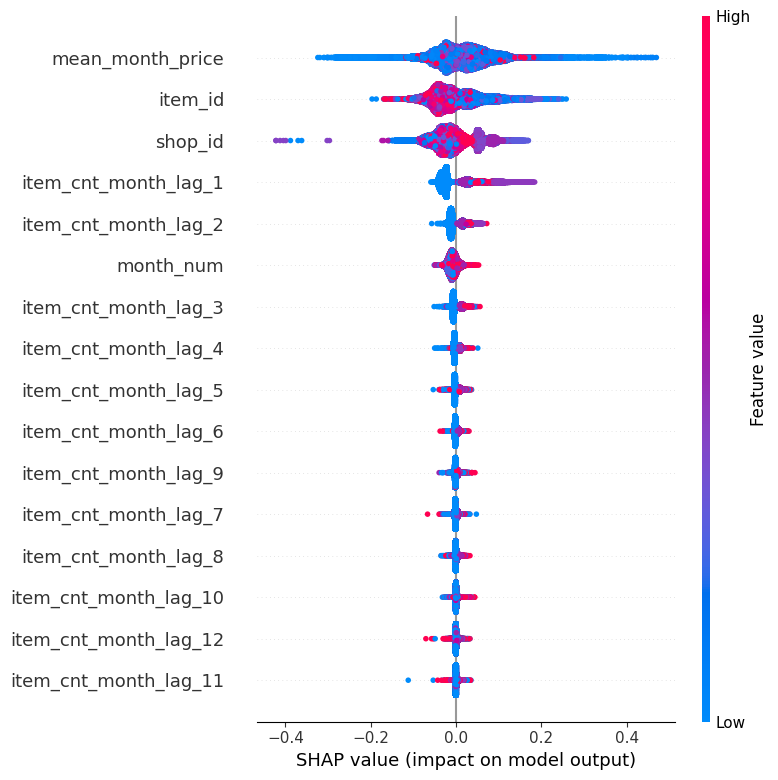

In [41]:
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

In [29]:
shap_values.shape

(482734, 16)

# Model Error Analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

class ModelErrorAnalysis:
    def __init__(self, model, X, y):
        self.model = model
        self.X = X
        self.y = y
        self.predictions = self.model.predict(self.X)
        self.errors = self.predictions - self.y

    def calculate_metrics(self):
        mae = np.mean(np.abs(self.errors))
        mse = mean_squared_error(self.y, self.predictions)
        rmse = np.sqrt(mse)
        return {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

    def plot_residuals(self):
        plt.figure(figsize=(10, 6))
        sns.residplot(self.predictions, self.errors, lowess=True, line_kws={'color': 'red', 'lw': 1})
        plt.title('Residuals Plot')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.show()

    def analyze_big_target(self, target_threshold):
        big_target_indices = self.y >= target_threshold
        big_target_errors = self.errors[big_target_indices]
        big_target_mae = np.mean(np.abs(big_target_errors))
        return big_target_mae

    def analyze_small_dynamic(self, dynamic_threshold):
        dynamic_indices = np.abs(self.y) <= dynamic_threshold
        dynamic_errors = self.errors[dynamic_indices]
        dynamic_mae = np.mean(np.abs(dynamic_errors))
        return dynamic_mae

    def find_influential_samples(self, threshold):
        influential_samples = np.abs(self.errors) > threshold
        return self.X[influential_samples], self.y[influential_samples], self.errors[influential_samples]

# Example usage:
# model_error_analysis = ModelErrorAnalysis(model, X_test, y_test)
# metrics = model_error_analysis.calculate_metrics()
# print("Model Metrics:", metrics)
# model_error_analysis.plot_residuals()
# big_target_mae = model_error_analysis.analyze_big_target(100)
# print("MAE for big targets:", big_target_mae)
# dynamic_mae = model_error_analysis.analyze_small_dynamic(10)
# print("MAE for small dynamic:", dynamic_mae)
# influential_X, influential_y, influential_errors = model_error_analysis.find_influential_samples(20)
# print("Influential Samples:", influential_X, influential_y, influential_errors)


# MODEL HYPERPARAMETER OPTIMIZATION

In [5]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

space = {
    'iterations': hp.choice('iterations', [100, 250, 500, 1000, 2000]),
    'depth': hp.choice('depth', [4, 6, 8, 10, 12]),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),  # экспоненциальный диапазон от 0.00001 до 1
    'random_strength': hp.loguniform('random_strength', -20, 0),  # экспоненциальный диапазон
    'border_count': hp.choice('border_count', [32, 64, 128, 254]),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
    'leaf_estimation_iterations': hp.choice('leaf_estimation_iterations', [1, 5, 10]),
    'leaf_estimation_method': hp.choice('leaf_estimation_method', ['Newton', 'Gradient']),
    'bootstrap_type': hp.choice('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
    'subsample': hp.uniform('subsample', 0.5, 1) if 'bootstrap_type' == 'Bernoulli' else None,  # Доступно только для Bernoulli
    'min_data_in_leaf': hp.choice('min_data_in_leaf', [1, 2, 5, 10, 20]),
    
    'use_best_model': hp.choice('use_best_model', [True, False]),
    'early_stopping_rounds': hp.choice('early_stopping_rounds', [10, 20, 50])
}

In [77]:
type(tpe.suggest)

function

In [6]:
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=.33, shuffle=False)

In [7]:
def objective(params):
    model = CatBoostRegressor(
        **params,
        task_type='CPU',
        loss_function='RMSE',
        eval_metric="RMSE",
        verbose=False
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    return {'loss': mse, 'status': STATUS_OK}

trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100, 
    trials=trials
)

print("Лучшие найденные гиперпараметры:")
print(best)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

  3%|▎         | 3/100 [05:34<3:00:23, 111.59s/trial, best loss: 0.32713818984673837]


KeyboardInterrupt: 

In [84]:
rfr = joblib.load("../models/Random Forest.pkl")

In [82]:
y_pred = rfr.predict(X_test)

ValueError: X has 16 features, but RandomForestRegressor is expecting 32 features as input.

In [48]:
space2 = {
    'iterations': hp.choice('iterations', [100, 250, 500, 1000, 2000]),
    'depth': hp.choice('depth', [4, 6, 8, 10, 12]),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),  # экспоненциальный диапазон от 0.00001 до 1
    'random_strength': hp.loguniform('random_strength', -20, 0),  # экспоненциальный диапазон
    'border_count': hp.choice('border_count', [32, 64, 128, 254]),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
    'leaf_estimation_iterations': hp.choice('leaf_estimation_iterations', [1, 5, 10]),
    'leaf_estimation_method': hp.choice('leaf_estimation_method', ['Newton', 'Gradient']),
    'bootstrap_type': hp.choice('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
    'subsample': hp.uniform('subsample', 0.5, 1) if 'bootstrap_type' == 'Bernoulli' else None,  # Доступно только для Bernoulli
    'min_data_in_leaf': hp.choice('min_data_in_leaf', [1, 2, 5, 10, 20]),
    
    'use_best_model': hp.choice('use_best_model', [True, False]),
    'early_stopping_rounds': hp.choice('early_stopping_rounds', [10, 20, 50])
}

In [53]:
from hyperopt import space_eval

cat_best_params = space_eval(space, best)

In [59]:
cat_best_params

{'bootstrap_type': 'MVS',
 'border_count': 254,
 'depth': 12,
 'early_stopping_rounds': 50,
 'iterations': 1000,
 'l2_leaf_reg': 5.063394590896299,
 'leaf_estimation_iterations': 10,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.06715832123249647,
 'min_data_in_leaf': 10,
 'random_strength': 0.599099648447859,
 'subsample': None,
 'use_best_model': False}

In [83]:
y_pred = mmm.predict(X_test)

root_mean_squared_error(y_pred, y_test)

0.5749731766976351

In [61]:
cat_best_params["use_best_model"] = True

In [75]:
cat_features_indices = [0, 1, 3]

In [67]:
train_df.head(1)

,shop_id,item_id,item_cnt_month,mean_month_price,month_num,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_7,item_cnt_month_lag_8,item_cnt_month_lag_9,item_cnt_month_lag_10,item_cnt_month_lag_11,item_cnt_month_lag_12
12,0,149,3.0,99.0,1,1.0,1.870712,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,1.870712


In [82]:
mmm = CatBoostRegressor(**cat_best_params, task_type='CPU',
        loss_function='RMSE',
        eval_metric="RMSE",
        verbose=False)
mmm.fit(X_train, y_train, eval_set=(X_valid, y_valid), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [84]:
mmm.save_model("../models/CatBoost", format="cbm")

# END

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609112 entries, 12 to 1609123
Data columns (total 17 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   shop_id                1609112 non-null  int64  
 1   item_id                1609112 non-null  int64  
 2   item_cnt_month         1609112 non-null  float64
 3   mean_month_price       1609112 non-null  float64
 4   month_num              1609112 non-null  int64  
 5   item_cnt_month_lag_1   1609112 non-null  float64
 6   item_cnt_month_lag_2   1609112 non-null  float64
 7   item_cnt_month_lag_3   1609112 non-null  float64
 8   item_cnt_month_lag_4   1609112 non-null  float64
 9   item_cnt_month_lag_5   1609112 non-null  float64
 10  item_cnt_month_lag_6   1609112 non-null  float64
 11  item_cnt_month_lag_7   1609112 non-null  float64
 12  item_cnt_month_lag_8   1609112 non-null  float64
 13  item_cnt_month_lag_9   1609112 non-null  float64
 14  item_cnt_month_la

In [1]:
# embedding size selection

emb_sizes = [2, 3, 5, 10, 20, 50, 100, 200]
results_rmse = []


for size in emb_sizes:
    emb_model = Word2Vec(sentences=shop_item_pairs, vector_size=size, window=2, min_count=1, workers=4)

    def data_preprocessing(X):
        X = X.tolist()
        X = [tuple(row) for row in X]

        X_emb = np.array([emb_model.wv[index_pair] for index_pair in X])

        X_embr = np.array(X_emb).reshape(X_emb.shape[0], X_emb.shape[1]*X_emb.shape[2])
        return X_emb, X_embr
    
    X_train_emb, X_train_embr = data_preprocessing(X_train)
    X_test_emb, X_test_embr = data_preprocessing(X_test)

    model = XGBRegressor()
    model.fit(X_train_embr, y_train)

    y_pred = model.predict(X_test_embr)

    rmse = root_mean_squared_error(y_test, y_pred)
    results_rmse.append(rmse)

NameError: name 'Word2Vec' is not defined

([<matplotlib.axis.XTick at 0x7e3dfb50dd20>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(20, 0, '20'),
  Text(50, 0, '50'),
  Text(100, 0, '100'),
  Text(200, 0, '200')])

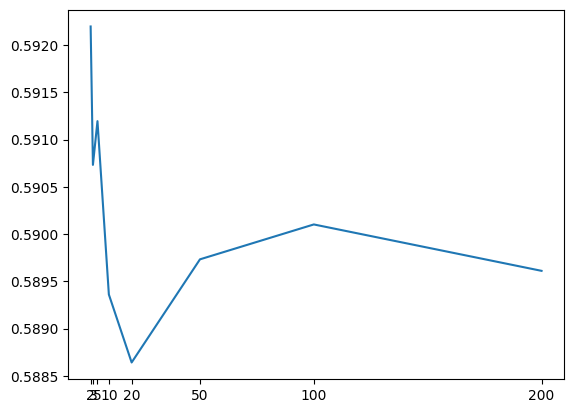

In [51]:
results_rmse = np.array(results_rmse)

plt.plot(np.array(emb_sizes), results_rmse)
plt.xticks(np.array(emb_sizes))

In [4]:
# import pandas as pd

# shop_item_gr = pd.DataFrame(sales_df.groupby(["shop_id", "item_id"])["item_cnt_day"].sum())
# shop_item_df = shop_item_gr.reset_index() # converting indexes into columns
# shop_item_df = shop_item_df[["shop_id", "item_id"]]

# shop_item_pairs = shop_item_df.values.tolist()
# shop_item_pairs = [tuple(row) for row in shop_item_pairs]

In [12]:
test_df = pd.read_csv("../data/raw/test.csv")

In [14]:
train_df.head()

,shop_id,item_id,item_cnt_month,mean_month_price,month_num
0,0,32,1.870712,221.0,1
1,0,33,3.000000,347.0,1
2,0,35,1.000000,247.0,1
3,0,43,1.000000,221.0,1
4,0,51,2.000000,128.5,1


In [17]:
test_df

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [16]:
train_df.month_num.value_counts()

month_num
1     152651
3     144473
2     140484
8     130960
7     129785
6     128082
4     124934
5     124808
12    119200
10    118763
9     115811
11     92534
Name: count, dtype: int64

In [13]:
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [11]:
shop_item_df = sales_df[["shop_id", "item_id"]]
test_shop_item_df = test_df[["shop_id", "item_id"]]

shop_item_pairs = np.concatenate((shop_item_df.values, test_shop_item_df.values), axis=0)
shop_item_pairs = shop_item_pairs.tolist()
shop_item_pairs = [tuple(row) for row in shop_item_pairs]

In [20]:
# DATA aggregation, embedding etc.
# Word2Vec embedding
from gensim.models import Word2Vec

emb_model = Word2Vec(sentences=shop_item_pairs, vector_size=20, window=2, min_count=1, workers=4)

In [21]:
def data_preprocessing(X):
    X = X.tolist()
    X = [tuple(row) for row in X]

    X_emb = np.array([emb_model.wv[index_pair] for index_pair in X])

    X_embr = np.array(X_emb).reshape(X_emb.shape[0], X_emb.shape[1]*X_emb.shape[2])
    return X_emb, X_embr

In [22]:
cat_emb, cat_embr = data_preprocessing(monthly_df.loc[:, ["shop_id", "item_id", "month_number"]].values)

In [92]:
monthly_df.head(1)

,month,shop_id,item_id,item_cnt_month,mean_month_price,month_number,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_7,item_cnt_month_lag_8,item_cnt_month_lag_9,item_cnt_month_lag_10,item_cnt_month_lag_11,item_cnt_month_lag_12
12,2013-01-01,0,149,3.0,99.0,1,1.0,1.870712,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,1.870712


In [23]:
mc = monthly_df.drop(["month", "item_cnt_month", "month_number", "shop_id", "item_id"], axis=1)

In [24]:
X = np.concatenate((cat_embr, mc.values), axis=1)

In [25]:
monthly_df = monthly_df.drop("month", axis=1)

In [12]:
monthly_df.head(1)

,month,shop_id,item_id,item_cnt_month,mean_month_price,month_number,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_7,item_cnt_month_lag_8,item_cnt_month_lag_9,item_cnt_month_lag_10,item_cnt_month_lag_11,item_cnt_month_lag_12
12,2013-01-01,0,149,3.0,99.0,1,1.0,1.870712,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,1.870712


In [13]:
X = monthly_df.drop(["month","item_cnt_month"], axis=1).values
y = monthly_df[["item_cnt_month"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [14]:
X_train.shape

(1126378, 16)

In [10]:
X_train_emb, X_train_embr = data_preprocessing(X_train)
X_test_emb, X_test_embr = data_preprocessing(X_test)

In [19]:
# INFERENCE FUNC

shop_id = 12
item_id = 44

model.wv[(shop_id, item_id)]


# VALIDATION CLASS
* Data Validation (Basic(проверка типов и положительность) + TFDV)
* Model Validation (TS Kfold Validation / Stratified Kfold Validation)

## Data Validation

### Basic

In [ ]:
new_sample = {
    "bedrooms": 3,
    "bathrooms": 2,
    "square_footage": 1500
}


# PREDICTION
try:
    validated_sample = HousingData(**new_sample)
    sample_for_prediction = scaler.transform([[validated_sample.bedrooms, validated_sample.bathrooms, validated_sample.square_footage]]) # FE 
    predicted_price = model.predict(sample_for_prediction)
    print(f"Predicted Price: {predicted_price[0]}")
except ValidationError as e:
    print("Validation Error:", e)

### TFDV

* (Q) Мы валидируем новые данные по схеме построенной на обработанных или сырах данных?

In [3]:
monthly_df = pd.read_csv("../data/processed/monthly_sales_full_processed.csv")

df = monthly_df

# changing field data types to obtain categorical statistics
df["item_id"] = df["item_id"].astype(str)
df["shop_id"] = df["shop_id"].astype(str)
df.drop("month", axis=1, inplace=True)


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609124 entries, 0 to 1609123
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   shop_id         1609124 non-null  object 
 1   item_id         1609124 non-null  object 
 2   item_cnt_month  1609124 non-null  float64
dtypes: float64(1), object(2)
memory usage: 36.8+ MB


In [13]:
train_data = df[["shop_id", "item_id"]]

In [14]:
train_data_DV = DV()

train_data_DV.create_stats(train_data)
train_data_DV.save_schema("train_data_schema")

There is no schema.
Trying to create a schema...
The scheme has been successfully created


,Type,Presence,Valency,Domain
Feature name,,,,
'shop_id',BYTES,required,,-
'item_id',BYTES,required,,-


The data schema has been successfully saved in ../data/data_schemas/train_data_schema.pbtxt


In [5]:
monthly_DV = DV()

monthly_DV.create_stats(df)
monthly_DV.create_schema()
monthly_DV.save_schema("data_schema")


There is no schema.
Trying to create a schema...
The scheme has been successfully created


,Type,Presence,Valency,Domain
Feature name,,,,
'shop_id',BYTES,required,,-
'item_id',BYTES,required,,-
'item_cnt_month',FLOAT,required,,-


The data schema has been successfully saved in ../data/data_schemas/data_schema.pbtxt


In [10]:
train, test = train_test_split(df, test_size=.3)

train.reset_index(drop=True, inplace=True)

In [11]:
train_DV = DV()
train_DV.create_stats(train)
train_DV.create_schema()

train_stats = train_DV.get_stats()

There is no schema.
Trying to create a schema...
The scheme has been successfully created


,Type,Presence,Valency,Domain
Feature name,,,,
'shop_id',BYTES,required,,-
'item_id',BYTES,required,,-
'item_cnt_month',FLOAT,required,,-


In [12]:
monthly_DV.validate_data(train_stats)

In [87]:
import tensorflow_data_validation as tfdv

stats = tfdv.generate_statistics_from_dataframe(df)
schema = tfdv.infer_schema(statistics=stats)

In [108]:
type("sdf") is pd.DataFrame

False

In [88]:
tfdv.visualize_statistics(stats)

In [113]:
tfdv.visualize_statistics(stats)
tfdv.display_schema(schema)
print("such")

,Type,Presence,Valency,Domain
Feature name,,,,
'shop_id',BYTES,required,,-
'item_id',BYTES,required,,-
'item_cnt_month',FLOAT,required,,-


such


In [115]:
type(stats)

tensorflow_metadata.proto.v0.statistics_pb2.DatasetFeatureStatisticsList

In [90]:
tfdv.write_schema_text(schema, "../data/data_schemas/monthly_sales_pr_schema.pbtxt")

In [ ]:
schema = tfdv.load_schema_text("../data/data_schemas/monthly_sales_pr_schema.pbtxt")

In [91]:
train, temp = train_test_split(df, test_size=.3, shuffle=False)

train.reset_index(drop=True, inplace=True)

In [92]:
valid, test = train_test_split(temp, test_size=.33, shuffle=False)

valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)


In [ ]:
monthly_sales.drop("month", axis=1, inplace=True)
monthly_sales.reset_index(drop=True, inplace=True)

In [59]:
monthly_sales["item_id"] = monthly_sales["item_id"].astype(str)
monthly_sales["shop_id"] = monthly_sales["shop_id"].astype(str)

In [99]:
# Генерация статистики для нового набора данных
stats_new = tfdv.generate_statistics_from_dataframe(train)

# Валидация новых данных на основе схемы
# anomalies = tfdv.validate_statistics(statistics=stats_new, schema=schema)

# Визуализация аномалий
# tfdv.display_anomalies(anomalies)


In [100]:
tfdv.visualize_statistics(lhs_statistics=stats, rhs_statistics=stats_new, lhs_name="Train Data Stats", rhs_name="New Data Stats")

In [101]:
tfdv.get_feature(schema, 'item_cnt_month').skew_comparator.infinity_norm.threshold = 0.5
tfdv.get_feature(schema, 'item_cnt_month').drift_comparator.infinity_norm.threshold = 0.5
anomalies = tfdv.validate_statistics(statistics=stats_new, schema=schema, serving_statistics=stats, previous_statistics=stats)

In [102]:
tfdv.display_anomalies(anomalies)

In [117]:
tt = {1 : 2, 3 : 4}
tt.items()

dict_items([(1, 2), (3, 4)])